<a href="https://colab.research.google.com/github/LizLian/from_scratch_2025/blob/main/batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title MLP implementation based on the following paper https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
with open('names.txt', 'r') as f:
    names = f.read().splitlines()
print(names[:10])
print(len(names))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [3]:
chars = sorted(list(set("".join(names))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi["."] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 3

def build_dataset(names):
  X, Y = [], []
  for word in names:
    context = [0] * block_size
    for ch in word + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))
Xtrain, Ytrain = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)*(n_embd*block_size)**0.5 #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# number of parameters in total
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12297


tensor(-0.0215) tensor(0.9997)
tensor(0.0018) tensor(3.1443)
tensor(-0.0084) tensor(0.9976)
tensor(0.0019) tensor(1.0056)


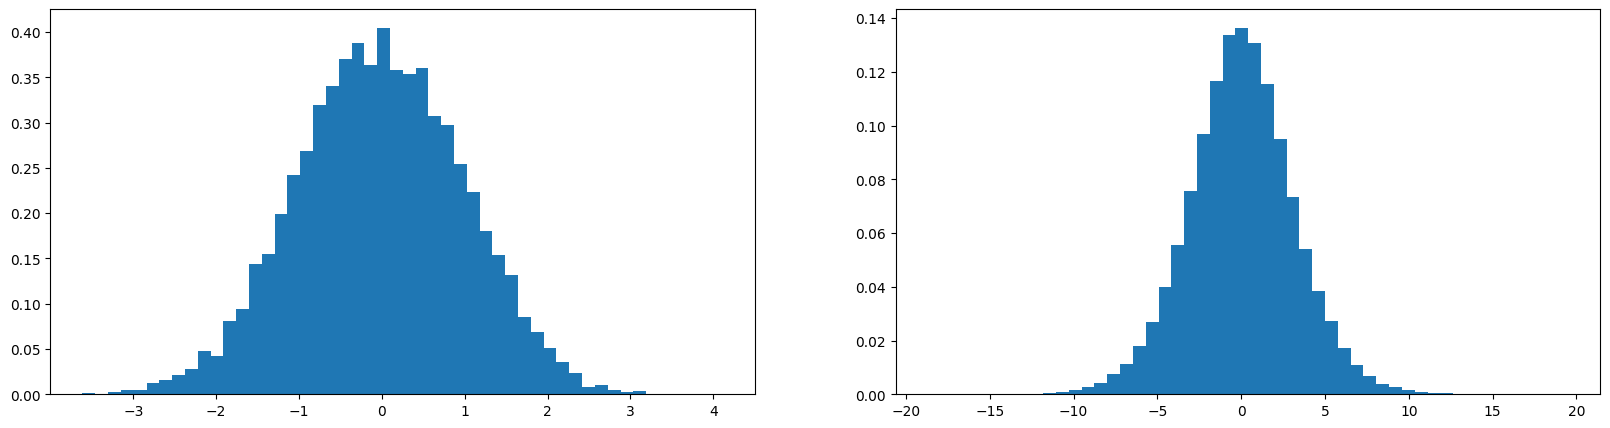

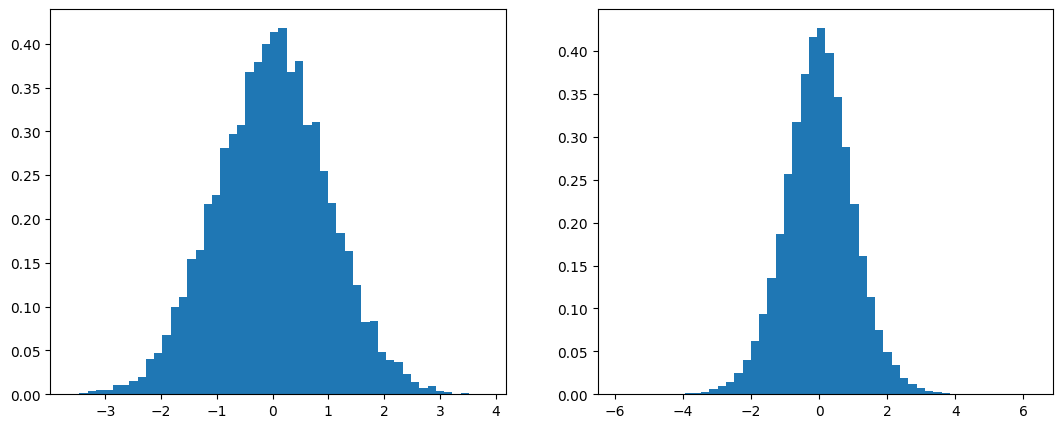

In [6]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
# x (the input) is standard normal distribution, we need to keep the output (y) the same distribution.
# right now the std of y is 3.17 and we aim at getting it to 1.
# empirically we'll achieve it by dividing w by the sqaure root of fan_in (number of inputs).
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# adjust w so that y follows std normal distribution
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(132)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtrain[ix], Ytrain[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # linear layer
  hpreact = embcat @ W1 + b1
  # BatchNorm layer
  # ------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # ------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  # cross entropy - manual
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(12), Y].log().mean()

  # cross entropy by pytorch
  loss = F.cross_entropy(logits, Yb)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # try different lr, 1 to -0.01, 1 is a exploding lr

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  # break


      0/ 200000: 3.3147
  10000/ 200000: 2.2387
  20000/ 200000: 2.4330
  30000/ 200000: 2.4949
  40000/ 200000: 1.9429
  50000/ 200000: 2.5044
  60000/ 200000: 2.4427
  70000/ 200000: 2.0587
  80000/ 200000: 2.3809
  90000/ 200000: 2.2332
 100000/ 200000: 2.1898
 110000/ 200000: 2.4085
 120000/ 200000: 2.1018
 130000/ 200000: 2.5740
 140000/ 200000: 2.4896
 150000/ 200000: 2.3274
 160000/ 200000: 2.0339
 170000/ 200000: 1.8523
 180000/ 200000: 2.2620
 190000/ 200000: 1.9991


In [8]:
#@title Estimate the loss
# the probablity of the next character should be uniform distribution = 1/27
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [9]:
#@ initialization
# the logits should be close to 0 when we initialize them to achieve low loss
# reasonable loss because logits were intialized close to 0s.
logits = torch.randn(4) # normal distribution
# high loss when logits are large. When the model is wrong, it's confidently wrong.
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # assuming the gt is the 2nd
logits, probs, loss

(tensor([ 1.1624,  4.5536, -4.8062, 24.1243]),
 tensor([1.0660e-10, 3.1661e-09, 2.7268e-13, 1.0000e+00]),
 tensor(28.9305))

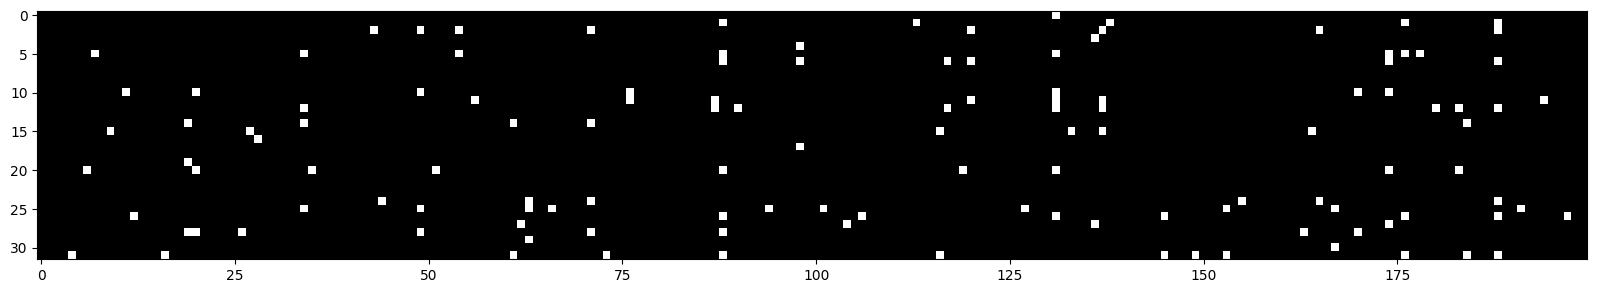

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
# white means the values of tanh are in the flat tail (dead neurons)

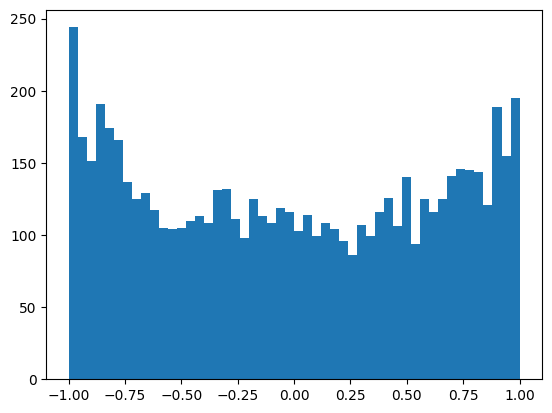

In [11]:
plt.hist(h.view(-1).tolist(), 50);
# backward in tanh -> grad += (1-t**2)*out.grad, if t is 1 or -1, grad is 0, there's no influence to the loss.


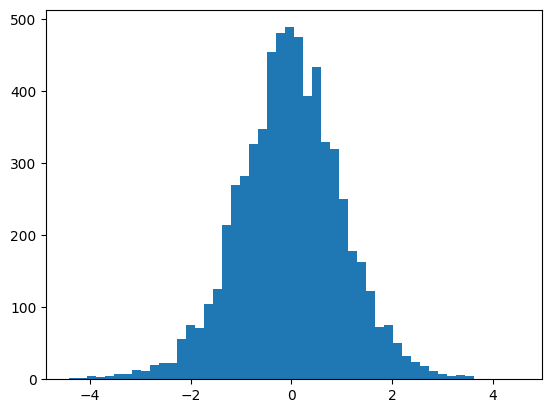

In [12]:
plt.hist(hpreact.view(-1).tolist(), 50);

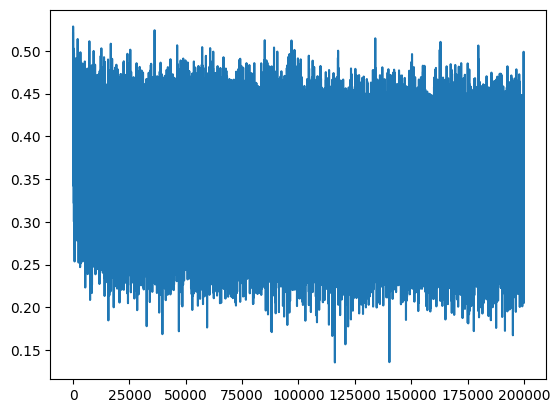

In [13]:
plt.plot(lossi)

In [14]:
#@title calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtrain]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean and std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [15]:
# train data loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      "train": (Xtrain, Ytrain),
      "val": (Xdev, Ydev),
      "test": (Xtest, Ytest),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.172891855239868
val 2.187286615371704


In [16]:
plt.plot(lri, lossi)
# we can see from the plot a good lr is when the exponent is -1 (lr = 0.1)

NameError: name 'lri' is not defined

In [ ]:
# loss log
# original:
train: 2.12
val: 2.17

# fix softmax confidentaly wrong
train:
val:

# fix tanh layer too saturated at init:
train: 2.0379111766815186
val: 2.101644515991211

# implement gain by activation function at init:


In [7]:
# @title modulize batchnorm layer
class Linear():
  def __init__(self, in_features, out_features, bias=True):
    self.weight = torch.randn((in_features, out_features), generator=g) / in_features**0.5
    self.bias = torch.zeros((out_features)) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([self.bias] if self.bias else [])


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


n_embd = 10
n_hidhen = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # make output softmax layer less confident
  layers[-1].gamma *= 0.1
  # all other layers, apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

173724


In [ ]:
max_steps = 100000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtrain[ix], Ytrain[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)

  for layer in layers:
    x = layer(x)

  # # linear layer
  # hpreact = embcat @ W1 + b1
  # # BatchNorm layer
  # # ------------------------------------------------------
  # bnmeani = hpreact.mean(0, keepdim=True)
  # bnstdi = hpreact.std(0, keepdim=True)
  # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # # ------------------------------------------------------
  # # Non-linearity
  # h = torch.tanh(hpreact)
  # logits = h @ W2 + b2

  # cross entropy - manual
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(12), Y].log().mean()

  # cross entropy by pytorch
  loss = F.cross_entropy(x, Yb)
  # print(loss.item())

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # try different lr, 1 to -0.01, 1 is a exploding lr

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  # break


      0/ 100000: 1.9913
  10000/ 100000: 2.5084
  20000/ 100000: 1.7352
  30000/ 100000: 2.2340


layer 2 (      Tanh): mean -0.01, std 0.67, saturated: 12.06%
layer 5 (      Tanh): mean -0.01, std 0.70, saturated: 14.58%
layer 8 (      Tanh): mean +0.03, std 0.73, saturated: 14.69%
layer 11 (      Tanh): mean +0.01, std 0.75, saturated: 13.53%
layer 14 (      Tanh): mean +0.02, std 0.77, saturated: 14.20%


/tmp/ipython-input-1254230750.py:7: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

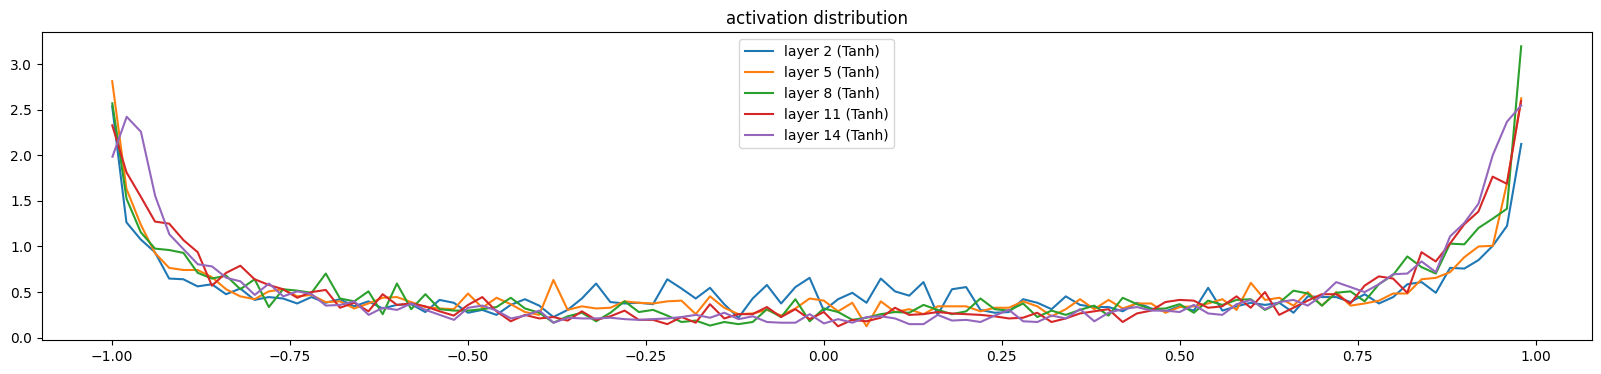

In [9]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution")

layer 2 (      Tanh): mean +0.000000, std 2.347155e-03
layer 5 (      Tanh): mean +0.000000, std 2.380560e-03
layer 8 (      Tanh): mean -0.000000, std 2.439756e-03
layer 11 (      Tanh): mean +0.000000, std 2.325750e-03
layer 14 (      Tanh): mean -0.000000, std 2.429716e-03


Text(0.5, 1.0, 'activation distribution')

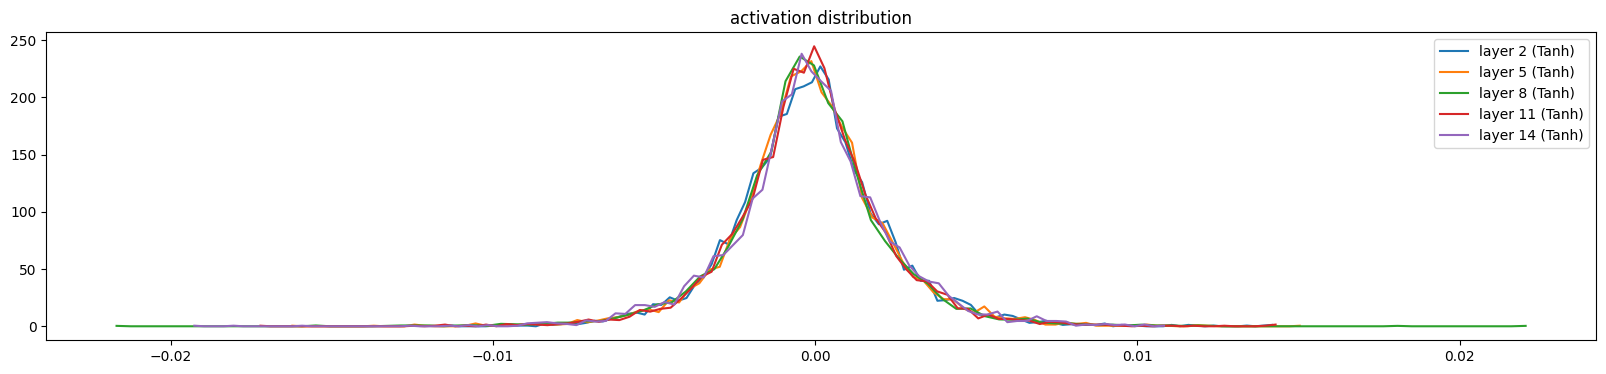

In [10]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("activation distribution")

weight   (27, 10) | mean -0.000000 | std 1.613851e-02 | grad:data ratio 1.490269e-02
weight  (30, 200) | mean -0.000123 | std 5.605717e-03 | grad:data ratio 1.586241e-02
weight (200, 200) | mean -0.000023 | std 3.356216e-03 | grad:data ratio 2.141141e-02
weight (200, 200) | mean -0.000019 | std 3.674214e-03 | grad:data ratio 2.354318e-02
weight (200, 200) | mean +0.000007 | std 3.530021e-03 | grad:data ratio 2.301615e-02
weight (200, 200) | mean -0.000004 | std 3.195186e-03 | grad:data ratio 2.181466e-02
weight  (200, 27) | mean -0.000212 | std 7.854134e-03 | grad:data ratio 3.160822e-02


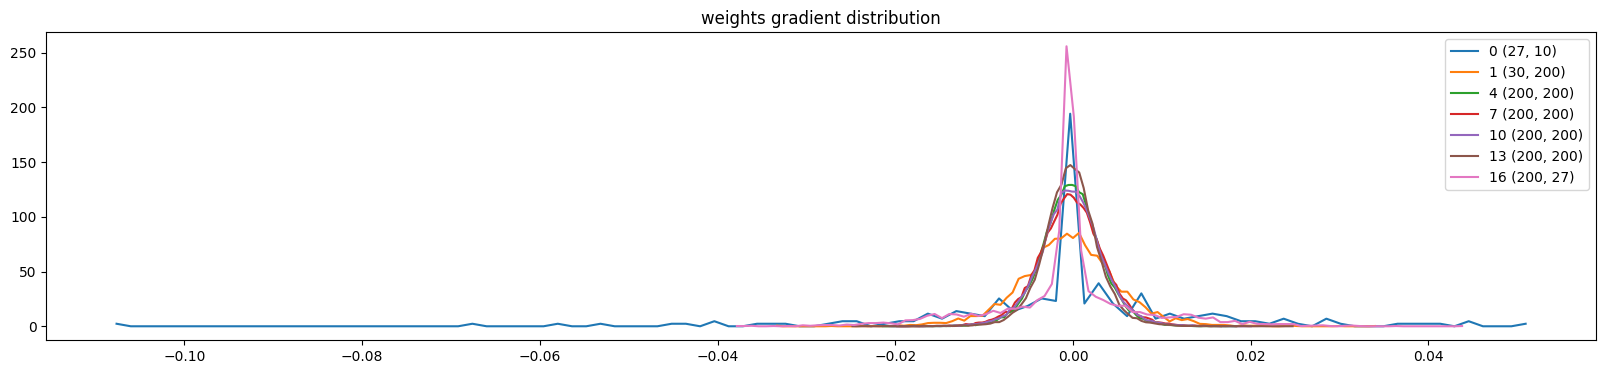

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

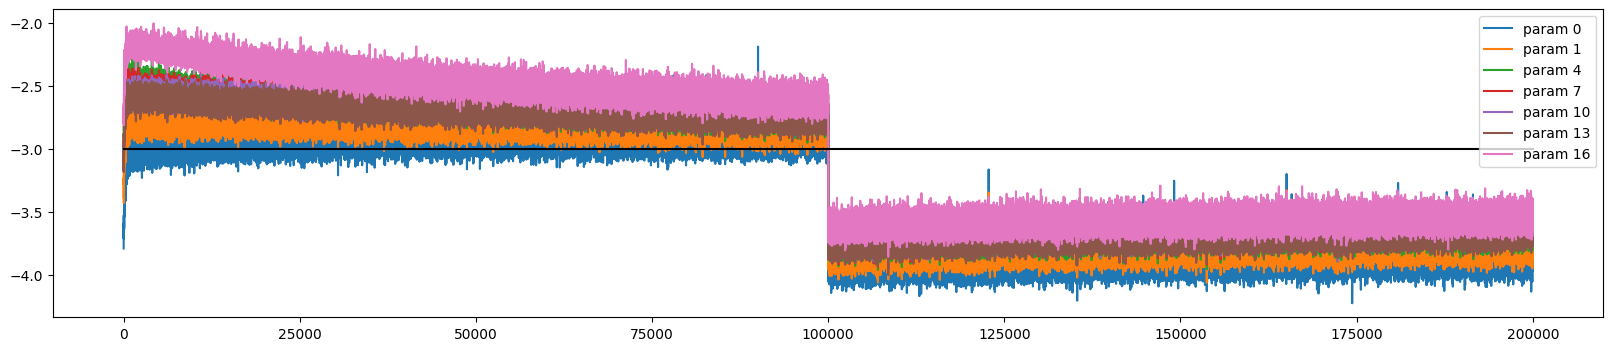

In [12]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [13]:
# train data loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      "train": (Xtrain, Ytrain),
      "val": (Xdev, Ydev),
      "test": (Xtest, Ytest),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss("train")
split_loss("val")

train 3.312739610671997
val 3.313340425491333


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

/tmp/ipython-input-1349143982.py:30: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  xvar = x.var(0, keepdim=True, unbiased=True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0